# MS-E2122 - Nonlinear Optimization
### Prof. Fabricio Oliveira

## Homework 2 - Problem 2.3

In [85]:
# Loading the packages we will need
using ForwardDiff      # Automatic differentiation
using LinearAlgebra    # For using norm()
using Test             # For implementing tests

# Shorthand to the functions to compute gradient and hessian. You can use these to complete parts of the code.
# Type \nabla + Tab to obtain ∇. 
∇(f,x) = ForwardDiff.gradient(f, x)
H(f,x) = ForwardDiff.hessian(f, x)

const tol = 1e-4      # unconstrained method convergence tolerance
const tol_ls = 1e-7   # line search convergence tolerance

1.0e-7

## Part 1: implementing the line search : Golden Section method

You are first required to implement the Golden section method as the exact line search to be used. Check the lecture notes for Lecture 5 for a detailed explanation of the method. 

Although it was not covered in class, this is a good opportunity for you to see if what you learn in class can help understand a new method that you haven't seen before, like it will probably be the case in your professional life!

### Input parameters:
- $\theta$: line search function
- $a$: initial lower bound
- $b$: initial upper bound

In [86]:
function golden_ls(θ; a=0.0, b=10.0, l=tol_ls)
    
    α  = 1/MathConstants.φ        # φ = golden ratio. Here α ≈ 0.618
    
    λ  = a + (1-α)*(b - a)        # NOTE: We do not need to index a, b, λ, and μ like in the lecture 5 pseudocode
    μ  = a + α*(b - a)            #       Instead, we can keep reusing and updating the same variables for notational convenience

    θμ = θ(a + α*(b - a))         # Use this variable to compute function values Θ(μₖ₊₁) as in the pseudocode of Lecture 5
    θλ = θ(a + (1 - α)*(b - a))   # Use this variable to compute function values Θ(λₖ₊₁) as in the pseudocode of Lecture 5
    
    # TODO: Implement what should be inside the while loop of Golden Section method. Use the variables defined above.
    while b - a > l
    # Include your code here, updating the values of λ and μ, 
    # testing which update to do (left or right move) and update 
    # the values of a, b, θλ, and θμ accordingly
        if θλ > θμ
            a = λ
            λ = μ
            μ = a + α*(b - a)
            θμ = θ(μ)
            θλ = θ(λ) 
        else
            b = μ
            μ = λ
            λ  = a + (1-α)*(b - a) 
            θλ = θ(λ)
            θμ = θ(μ)
        end
    end
    return (a + b)/2              # Finally, the function returns the center point of the final interval
end

golden_ls (generic function with 1 method)

## Test functions

Use the functions below to test your code. The correct results is commented beside it.

*Tip:* if you want to see the value of any expression you can use the macro `@show`.

Example: 
`@show golden_ls(θ1, a, b)`

In [87]:
# Tests
θ1(x) = 3x^2 -4x + 6           # Optimal value x = 2/3
θ2(x) = exp(x) - 10x^2 - 20x   # Optimal value x = 4.743864 (in [0,10])

@test abs(golden_ls(θ1) - 2/3) <= 1e-4
@test abs(golden_ls(θ2) - 4.743864) <= 1e-4

Test Passed

## Part 2: implementing the Gradient Descent method

We will now implement the gradient descent method. Below we list all the inputs and outputs we considered for reference.

### Inputs
- f: function to minimize (mandatory)
- x_start: starting point
- max_steps: maximum number of iterations
- ϵ: convergence tolerance.

### Outputs
Return the tuple `(x_iter, f(x), k-1)` 
- x_iter: a matrix with n columns and as many rows as iterations with each point visited
- f(x): function value of all points visited
- k-1: number of iterations, discounted the "iteration 0" for which k = 1.

In [88]:
function gradient(f; x_start=[0,0], max_steps=1000, ϵ=tol)
    
    x = zeros(max_steps, length(x_start))                 # To save the history of iterations
    x = vcat(x_start', x)                                 # Including starting point                           

    for k = 1:max_steps                                   # Main iteration loop
        
        ∇f = ∇(f, x[k,:])                                 # Gradient at iteration k

        if norm(∇f) < ϵ                                   # Stopping condition: norm of the gradient < tolerance     
            
            return (x[1:k,:], f.(x[i,:] for i=1:k), k-1)  # Return iteration points, function values, and number of iterations
        end                                               # (k-1) as k=1 is "iteration 0".      
        
        # TODO: set the Gradient Descent direction (do not forget to normalise d)
        d = -∇f/norm(∇f)
        
        θ(λ) = f(x[k,:] + λ*d)      # Define the line search function 
        λ    = golden_ls(θ)         # Call Golden Section method to compute optimal step size λ  

        # TODO: Update the solution x[k+1,:] at this iteration accordingly
        x[k+1,:] = x[k,:] + λ*d
    
    end

    return (x, f.(x[i,:] for i=1:max_steps), max_steps)    # Return iteration points, function values, and number of iterations
end

gradient (generic function with 1 method)

### Testing the gradient descent method

The cell below implement tests to validate your implementation of the gradient method. We use the same functions for the other methods too.

In [89]:
# Test functions 
f(x) = 0.26*(x[1]^2 + x[2]^2) - 0.48*x[1]*x[2]  # x_opt = (0,0) and f(x_opt) = 0.
g(x) = exp(x[1] + 3*x[2] - 0.1) + exp(x[1] - 3*x[2] - 0.1) + exp(-x[1] - 0.1) # x_opt ≈ (-0.346574, 0.0) and f(x_opt) = 2.55927
                     
# Testing f(x)
x = [7.0, 3.0]                        # Starting point (7.0,3.0)
(xg, fg, kg) = gradient(f, x_start=x)
@test norm(xg[end,:] - [0.0, 0.0]) <= 1e-2
@test abs(fg[end] - 0.0) <= 1e-2
      
# Testing g(x)
x = [-4.0, -2.0]                      # Starting point (-4.0,-2.0)
(xg, fg, kg) = gradient(g, x_start=x)
@test norm(xg[end,:] - [-0.346574, 0.0]) <= 1e-2
@test abs(fg[end] - 2.55927) <= 1e-2

Test Passed

You can recover the elements of the solution by calling the function as above and then printing (or showing with `@show`) each element.

In [90]:
(xg, fg, kg) = gradient(f, x_start=x)
println("Optimal solution: $(xg[end,:])")
println("Optimal value: $(fg[end])")
println("Total iterations:  $(kg)")

Optimal solution: [-0.0006009155217226521, -0.0006066981019599359]
Optimal value: 1.4591666199588129e-8
Total iterations:  13


## Part 3: Newton's method

### Inputs
- f: function to minimize (mandatory)
- x_start: starting point
- max_steps: maximum number of iterations
- ϵ: convergence tolerance.

### Outputs
Return the tuple `(x_iter, f(x), k-1)` 
- x_iter: a matrix with n columns and as many rows as iterations with each point visited
- f(x): function value of all points visited
- k-1: number of iterations, discounted the "iteration 0" for which k = 1.

In [91]:
function newton(f; x_start=[0,0], max_steps=1000, ϵ=tol)
    
    x = zeros(max_steps, length(x_start))   # To save the history of iterations
    x = vcat(x_start', x)                   # Including starting point 
    
    for k = 1:max_steps                     # Main iteration loop
        
        ∇f = ∇(f, x[k,:])                   # Gradient at iteration k
         
        if norm(∇f) < ϵ                                      # Stopping condition: norm of the gradient < tolerance
            return (x[1:k,:], f.(x[i,:] for i = 1:k), k-1)   # Return iteration points, function values, and number of iterations
        end
        
        # TODO: Update the newton direction
        Hf = -H(f, x[k,:])
        d = inv(Hf)*∇f

        θ(λ) = f(x[k,:] + λ*d)     # Define the line search function 
        λ = golden_ls(θ)           # Call Golden Section method to compute optimal step size λ  

        # TODO: Update the solution x[k+1,:] at this iteration accordingly
        x[k+1,:] = x[k,:] + λ*d
    end
    
    return (x, f.(x[i,:] for i = 1:max_steps), max_steps)    # Return iteration points, function values, and number of iterations
end

newton (generic function with 1 method)

### Testing the Newton's method

In [92]:
# Test functions (everything is the same as before, expect for the functin newton() call)
f(x) = 0.26*(x[1]^2 + x[2]^2) - 0.48*x[1]*x[2]  # x_opt = (0,0) and f(x_opt) = 0.
g(x) = exp(x[1] + 3*x[2] - 0.1) + exp(x[1] - 3*x[2] - 0.1) + exp(-x[1] - 0.1) # x_opt ≈ (-0.346574, 0.0) and f(x_opt) = 2.55927

# Testing f(x)
x = [7.0, 3.0]                 # Starting point (7.0,3.0)
(xg, fg, kg) = newton(f, x_start=x)
@test norm(xg[end,:] - [0.0, 0.0]) <= 1e-2
@test abs(fg[end] - 0.0) <=1e-2
      
# Testing g(x)
x = [-4.0, -2.0]               # Starting point (-4.0,-2.0)
(xg, fg, kg) = newton(g, x_start=x)
@test norm(xg[end,:] - [-0.346574, 0.0]) <= 1e-2
@test abs(fg[end] - 2.55927) <=1e-2

Test Passed

## Conjugate Gradient

### Inputs
- f: function to minimize (mandatory)
- x_start: starting point
- max_steps: maximum number of iterations
- ϵ: convergence tolerance.

### Outputs
Return the tuple `(x_iter, f(x), k-1)` 
- x_iter: a matrix with n columns and as many rows as iterations with each point visited
- f(x): function value of all points visited
- k-1: number of iterations, discounted the "iteration 0" for which k = 1.

In [135]:
function conjugate_gradient(f; x_start=[0,0], max_steps=1000, ϵ=tol)
      
    α = 0.0              # Coefficient for Fletcher-Reeves update
    k = 1                # Iteration number  
    n = length(x_start)  # Dimension of x
    d = -∇(f, x_start)   # Initial direction vector

    x = zeros(max_steps, length(x_start))   # To save the history of iterations
    x = vcat(x_start', x)                   # Including starting point 
    
    while k <= max_steps   # Go through max iterations N and return if at optimum 
        
        for j = 1:n        # Go through each element of x. NOTE: We do not need to use y variables. Instead, 
                           # we can use the empty values in the x variable vector 

            θ(λ) = f(x[k,:] + λ*d)   # Define the line search function 
            λ = golden_ls(θ)   # Call Golden Section method to compute optimal step size λ  
            
            # TODO: Update the value of x[k+1,:] accordingly
            x[k+1,:] = x[k,:] + λ*d

            # TODO: Compute value of α using the Fletcher-Reeves update formula
            ∇Fₜ₊₁=∇(f, x[k+1,:])
            α = (norm(∇Fₜ₊₁))^2/(norm(d))^2#d^2/(∇Fₜ₊₁'*∇Fₜ₊₁)

            # TODO: Set the direction vector accordingly
            d = α*d + -∇Fₜ₊₁
            
            k = k + 1   # Update number of iterations for the y values (here we use x vector instead as mentioned earlier)
            
        end
        
        d = -∇(f, x[k,:]) # Setting d to the gradient for the next cycle of iterations 
        
        if norm(d) < ϵ                                      # Stopping condition: norm of the gradient < tolerance
            return (x[1:k,:], f.(x[i,:] for i = 1:k), k-1)  # Return iteration points, function values, and number of iterations
        end
        
    end
    
    return (x, f.(x[i,:] for i = 1:max_steps), max_steps)    # Return iteration points, function values, and number of iterations
    
end

conjugate_gradient (generic function with 1 method)

### Testing the conjugate gradient method

In [136]:
# Test functions (everything is the same as before, expect for the functin conjugate_gradient() call)
f(x) = 0.26*(x[1]^2 + x[2]^2) - 0.48*x[1]*x[2]  # x_opt = (0,0) and f(x_opt) = 0.
g(x) = exp(x[1] + 3*x[2] - 0.1) + exp(x[1] - 3*x[2] - 0.1) + exp(-x[1] - 0.1) # x_opt ≈ (-0.346574, 0.0) and f(x_opt) = 2.55927

# Testing f(x)
x = [7.0, 3.0]                                      # Starting point (7.0,3.0)
(xg, fg, kg) = conjugate_gradient(f, x_start=x)
@test norm(xg[end,:] - [0.0, 0.0]) <= 1e-2
@test abs(fg[end] - 0.0) <=1e-2
      
# Testing g(x)
x = [-4.0, -2.0]                                    # Starting point (-4.0,-2.0) 
(xg, fg, kg) = conjugate_gradient(g, x_start=x)
@test norm(xg[end,:] - [-0.346574, 0.0]) <= 1e-2
@test abs(fg[end] - 2.55927) <=1e-2

Test Passed

## Plotting the convergence trajectories of the methods

If the above implementations were done correctly, the code below should generate a similar picture to those used in the classes. We will be using your implementaion of the methods to calculate the optimal trajectories and plot the three methods side by side.

Tip: You can use this code as a reference to make plots in the future assignments.

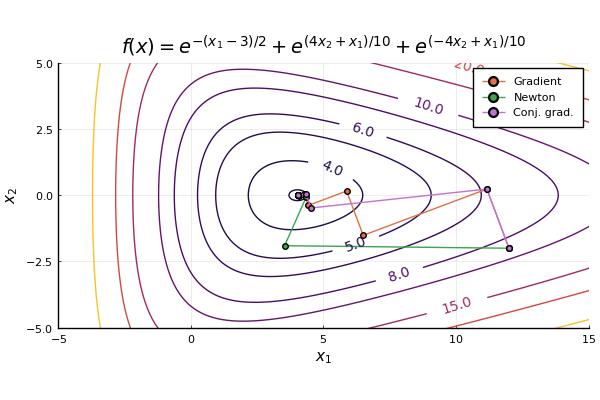

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [137]:
using Plots 
using LaTeXStrings   # For plotting LaTeX code in tags
pyplot()

f(x) = exp(-(x[1]-3)/2) + exp((4x[2] + x[1])/10) + exp((-4x[2] + x[1])/10) # standard function
# Plotting the contours of the function to be optimised
n = 1000
x1 = range(-10, 25, length=n);
x2 = range(-10, 10, length=n);

contour(x1, x2, (x1,x2) -> f([x1,x2]),
        levels = [3.6, 4, 5, 6 , 8, 10, 15, 20, 30], # set which level curves to plot
        xaxis = (L"$x_1$", (-5,15)),                 # L means we are usign LaTeX notation
        yaxis = (L"$x_2$", (-5,5)),
        title = L"$f(x) = e^{-(x_1-3)/2} + e^{(4x_2 + x_1)/10} + e^{(-4x_2 + x_1)/10}$",  
        clims = (0,35),
        contour_labels = true,
        cbar = false,
        aspect_ratio = :equal
        )

# The optimal value of x for standard function:
xopt = [-(5/6)*(-3 + 2*log(2) - 2*log(5)), 0]
fopt = f(xopt)

# Testing f(x)
x = [12.0, -2.0]
(xg,⋅,⋅) = gradient(f, x_start=x) # We use \cdot to discard outputs we do not need
(xn,⋅,⋅) = newton(f, x_start=x)
(xc,⋅,⋅) = conjugate_gradient(f, x_start=x)

plot!( xg[:,1], xg[:,2], label = "Gradient", marker=:circle)
plot!( xn[:,1], xn[:,2], label = "Newton", marker=:circle)
plot!( xc[:,1], xc[:,2], label = "Conj. grad.", marker=:circle)

In [142]:
# Answers to b and do
f(x) = 0.26*(x[1]^2+x[2]^2)-0.48*x[1]*x[2]
g(x) = exp(x[1]+3*x[2]-0.1)+exp(x[1]-3*x[2]-0.1)+exp(-x[1]-0.1)
f_init = [7,3]
g_init= [-4,-2]
(⋅, ⋅, ifgm) = gradient(f, x_start=f_init)
(⋅, ⋅, iggm) = gradient(g, x_start=g_init)
(⋅, ⋅, ifnm) = newton(f, x_start=f_init)
(⋅, ⋅, ignm) = newton(g, x_start=g_init)
(⋅, ⋅, ifcgm) = conjugate_gradient(f, x_start=f_init)
(⋅, ⋅, igcgm) = conjugate_gradient(g, x_start=g_init);

In [143]:
println("Total iterations for the gradient method for f(x):  $(ifgm)")
println("Total iterations for the newton method for f(x):  $(ifnm)")
println("Total iterations for the conjugate gradient method for f(x):  $(ifcgm)")

Total iterations for the gradient method for f(x):  11
Total iterations for the newton method for f(x):  1
Total iterations for the conjugate gradient method for f(x):  8


In [144]:
println("Total iterations for the gradient method for g(x):  $(iggm)")
println("Total iterations for the newton method for g(x):  $(ignm)")
println("Total iterations for the conjugate gradient method for g(x):  $(igcgm)")

Total iterations for the gradient method for g(x):  18
Total iterations for the newton method for g(x):  4
Total iterations for the conjugate gradient method for g(x):  6
